# 1. 데이터 준비

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import os
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant
from gensim.models import KeyedVectors
from konlpy.tag import Mecab

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 2. 데이터로더 구성

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [2]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True) # 중복값 제거
    train_data = train_data.dropna(how = 'any')  # NA값 제거
    
    test_data.drop_duplicates(subset=['document'], inplace=True) # 중복값 제거
    test_data = test_data.dropna(how = 'any')  # NA값 제거 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)} # 딕셔너리에 {텍스트:인덱스} 구조로 저장
    
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<PAD>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [4]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))

훈련 샘플 개수: 146182, 테스트 개수: 49157


In [5]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [6]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 3. 모델구성을 위한 데이터 분석 및 가공

- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [7]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [8]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [9]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)
print(X_test.shape)

(146182, 41)
(49157, 41)


# 4. 모델구성 및 validation set 구성

- 모델을 3가지 이상 다양하게 구성할 것

In [10]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 32  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

## 1.LSTM

In [11]:
model1 = keras.Sequential()
model1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model1.add(keras.layers.Dense(8, activation='relu'))
model1.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 1312      
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 321,393
Trainable params: 321,393
Non-trainable params: 0
_________________________________________________________________


## 2. GlobalMaxPooling1D()

In [12]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(keras.layers.GlobalMaxPooling1D())
model2.add(keras.layers.Dense(8, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 320,273
Trainable params: 320,273
Non-trainable params: 0
_________________________________________________________________


## 3.Convolution Neural Network(1-D CNN)

In [13]:
model3 = keras.Sequential()
model3.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(keras.layers.Conv1D(16, 7, activation='relu'))
model3.add(keras.layers.MaxPooling1D(5))
model3.add(keras.layers.Conv1D(16, 7, activation='relu'))
model3.add(keras.layers.GlobalMaxPooling1D())
model3.add(keras.layers.Dense(8, activation='relu'))
model3.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          3600      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [14]:
# validation set 30000건 분리
X_val = X_train[:30000]   
y_val = y_train[:30000]

# validation set을 제외한 나머지 116182건
partial_X_train = X_train[30000:]  
partial_y_train = y_train[30000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(116182, 41)
(116182,)


## 5. 모델 훈련 개시

In [15]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history1 = model1.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
227/227 [==============================] - 21s 7ms/step - loss: 0.6237 - accuracy: 0.6257 - val_loss: 0.4614 - val_accuracy: 0.8211
Epoch 2/20
227/227 [==============================] - 1s 5ms/step - loss: 0.3880 - accuracy: 0.8401 - val_loss: 0.3653 - val_accuracy: 0.8465
Epoch 3/20
227/227 [==============================] - 1s 5ms/step - loss: 0.3294 - accuracy: 0.8635 - val_loss: 0.3508 - val_accuracy: 0.8509
Epoch 4/20
227/227 [==============================] - 1s 5ms/step - loss: 0.3087 - accuracy: 0.8715 - val_loss: 0.3512 - val_accuracy: 0.8499
Epoch 5/20
227/227 [==============================] - 1s 5ms/step - loss: 0.2961 - accuracy: 0.8770 - val_loss: 0.3565 - val_accuracy: 0.8486
Epoch 6/20
227/227 [==============================] - 1s 5ms/step - loss: 0.2848 - accuracy: 0.8818 - val_loss: 0.3654 - val_accuracy: 0.8471
Epoch 7/20
227/227 [==============================] - 1s 5ms/step - loss: 0.2721 - accuracy: 0.8875 - val_loss: 0.3720 - val_accuracy: 0.8455
Epoch

In [16]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history2 = model2.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
227/227 [==============================] - 1s 4ms/step - loss: 0.5549 - accuracy: 0.7778 - val_loss: 0.3894 - val_accuracy: 0.8322
Epoch 2/20
227/227 [==============================] - 1s 3ms/step - loss: 0.3533 - accuracy: 0.8477 - val_loss: 0.3485 - val_accuracy: 0.8471
Epoch 3/20
227/227 [==============================] - 1s 3ms/step - loss: 0.3071 - accuracy: 0.8715 - val_loss: 0.3432 - val_accuracy: 0.8510
Epoch 4/20
227/227 [==============================] - 1s 3ms/step - loss: 0.2775 - accuracy: 0.8860 - val_loss: 0.3465 - val_accuracy: 0.8527
Epoch 5/20
227/227 [==============================] - 1s 4ms/step - loss: 0.2536 - accuracy: 0.8983 - val_loss: 0.3564 - val_accuracy: 0.8524
Epoch 6/20
227/227 [==============================] - 1s 3ms/step - loss: 0.2323 - accuracy: 0.9081 - val_loss: 0.3665 - val_accuracy: 0.8504
Epoch 7/20
227/227 [==============================] - 1s 3ms/step - loss: 0.2132 - accuracy: 0.9172 - val_loss: 0.3820 - val_accuracy: 0.8486
Epoch 

In [17]:
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history3 = model3.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
227/227 [==============================] - 13s 7ms/step - loss: 0.4916 - accuracy: 0.7561 - val_loss: 0.3574 - val_accuracy: 0.8434
Epoch 2/20
227/227 [==============================] - 1s 4ms/step - loss: 0.3291 - accuracy: 0.8601 - val_loss: 0.3445 - val_accuracy: 0.8493
Epoch 3/20
227/227 [==============================] - 1s 4ms/step - loss: 0.2960 - accuracy: 0.8770 - val_loss: 0.3394 - val_accuracy: 0.8528
Epoch 4/20
227/227 [==============================] - 1s 5ms/step - loss: 0.2681 - accuracy: 0.8920 - val_loss: 0.3476 - val_accuracy: 0.8488
Epoch 5/20
227/227 [==============================] - 1s 4ms/step - loss: 0.2370 - accuracy: 0.9075 - val_loss: 0.3544 - val_accuracy: 0.8492
Epoch 6/20
227/227 [==============================] - 1s 5ms/step - loss: 0.1993 - accuracy: 0.9256 - val_loss: 0.3816 - val_accuracy: 0.8478
Epoch 7/20
227/227 [==============================] - 1s 5ms/step - loss: 0.1595 - accuracy: 0.9437 - val_loss: 0.4191 - val_accuracy: 0.8414
Epoch

In [18]:
results1 = model1.evaluate(X_test,  y_test, verbose=2)
results2 = model2.evaluate(X_test,  y_test, verbose=2)
results3 = model3.evaluate(X_test,  y_test, verbose=2)


1537/1537 - 3s - loss: 0.5061 - accuracy: 0.8372
1537/1537 - 2s - loss: 0.6974 - accuracy: 0.8212
1537/1537 - 2s - loss: 1.0599 - accuracy: 0.8170


## 6. Loss,Accuracy 그래프 시각화

In [19]:
history1_dict = history1.history
history2_dict = history2.history
history3_dict = history3.history

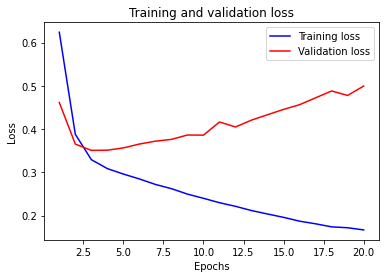

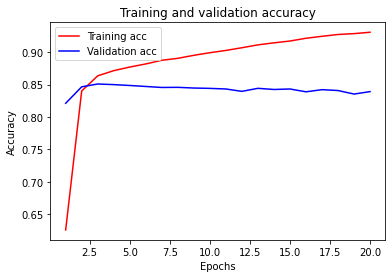

In [46]:
import matplotlib.pyplot as plt

acc = history1_dict['accuracy']
val_acc = history1_dict['val_accuracy']
loss = history1_dict['loss']
val_loss = history1_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

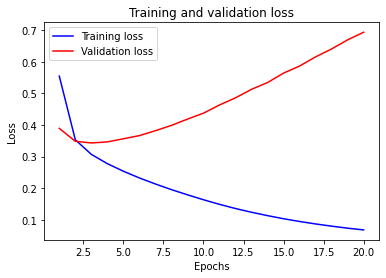

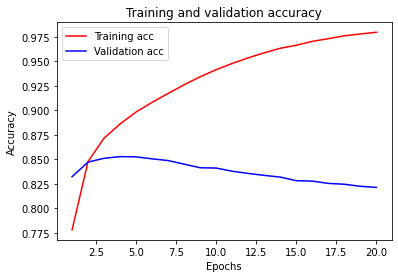

In [47]:
import matplotlib.pyplot as plt

acc = history2_dict['accuracy']
val_acc = history2_dict['val_accuracy']
loss = history2_dict['loss']
val_loss = history2_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

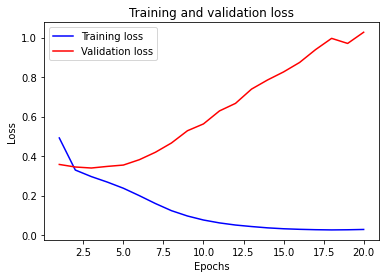

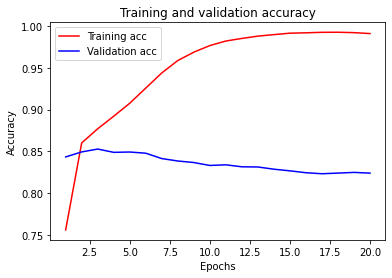

In [48]:
import matplotlib.pyplot as plt

acc = history3_dict['accuracy']
val_acc = history3_dict['val_accuracy']
loss = history3_dict['loss']
val_loss = history3_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 7. 학습된 Embedding 레이어 분석

In [23]:
embedding_layer = model1.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 32)


In [24]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model1.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [25]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['만족']
vector

array([-0.13323578,  0.01504288,  0.10560352, -0.157645  , -0.12246255,
        0.1366448 ,  0.16019493, -0.06854194,  0.00827689, -0.06568895,
        0.07891641, -0.12074707, -0.00926329,  0.15738457,  0.09559022,
       -0.07864477, -0.03856812,  0.06679559, -0.16297099,  0.18849999,
       -0.02935623, -0.03209349, -0.0885696 ,  0.09842441, -0.17806444,
       -0.12721245,  0.15511054, -0.00454989, -0.15177232,  0.0073503 ,
        0.22091779,  0.22459702], dtype=float32)

In [26]:
word_vectors.similar_by_word("어벤져스")

[('맷데이먼', 0.9352104663848877),
 ('지닌', 0.9320454001426697),
 ('불러일으키', 0.9248889684677124),
 ('사악', 0.9241040945053101),
 ('서부터', 0.9240542054176331),
 ('백제', 0.9219959378242493),
 ('꽉', 0.9181508421897888),
 ('~~!!!', 0.9166092276573181),
 ('장식', 0.9161637425422668),
 ('시끄러워서', 0.9115396738052368)]

## 8. 한국어 Word2Vec 임베딩 활용하여 성능개선

In [27]:
from gensim.models import Word2Vec

In [28]:
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'

In [29]:
word2vec = Word2Vec.load(word2vec_path)

In [30]:
vector = word2vec['사랑']
vector

/tmp/ipykernel_530/3818210802.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['사랑']


array([-1.3740246 , -1.7353463 ,  3.3915305 , -2.569253  , -1.4016607 ,
        1.4556127 ,  0.9414557 ,  1.9207907 ,  0.16471806,  0.4838317 ,
       -0.8547181 ,  2.0879807 ,  0.86741775,  0.87539405, -0.09962013,
        0.22928311, -1.1858722 ,  0.00858838,  1.4999928 , -0.16196461,
       -0.35184434, -0.92390764,  1.0849575 ,  0.3025011 ,  2.7021565 ,
       -1.0263684 ,  0.32864776, -0.76589465, -2.510981  , -0.66225356,
        2.8434615 ,  0.50130975, -1.021874  , -1.4366034 ,  1.1110784 ,
        0.5812605 , -0.5830406 , -0.5785423 ,  1.3634988 ,  2.3074338 ,
       -1.4314893 ,  0.45745876,  1.1073523 , -3.2135262 , -0.2898375 ,
       -1.1622221 ,  1.2369208 , -0.7622987 , -0.37757635,  1.1376442 ,
        0.01065568, -0.69105595,  1.5159112 ,  1.1534518 , -1.0119992 ,
       -0.5757404 ,  1.1349088 , -1.1289831 ,  0.13004152,  2.0451715 ,
       -0.23940353,  1.3604902 ,  0.72700524,  0.32545742,  1.0612459 ,
        0.42252553,  1.1442151 ,  2.8774905 ,  2.4377263 , -1.34

In [33]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_530/1730871920.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_530/1730871920.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [55]:
# 모델 구성
model4 = keras.Sequential()
model4.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen,
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model4.add(keras.layers.LSTM(512))
model4.add(keras.layers.Dense(8, activation='relu'))
model4.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 512)               1460224   
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 4104      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 3,464,337
Trainable params: 3,464,337
Non-trainable params: 0
_________________________________________________________________


In [56]:
model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history4 = model4.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
286/286 [==============================] - 21s 67ms/step - loss: 0.6792 - accuracy: 0.5331 - val_loss: 0.5379 - val_accuracy: 0.7321
Epoch 2/10
286/286 [==============================] - 20s 69ms/step - loss: 0.3914 - accuracy: 0.8228 - val_loss: 0.2958 - val_accuracy: 0.8772
Epoch 3/10
286/286 [==============================] - 20s 69ms/step - loss: 0.2928 - accuracy: 0.8762 - val_loss: 0.2455 - val_accuracy: 0.9007
Epoch 4/10
286/286 [==============================] - 20s 69ms/step - loss: 0.2522 - accuracy: 0.8960 - val_loss: 0.2107 - val_accuracy: 0.9188
Epoch 5/10
286/286 [==============================] - 20s 70ms/step - loss: 0.2157 - accuracy: 0.9135 - val_loss: 0.1679 - val_accuracy: 0.9394
Epoch 6/10
286/286 [==============================] - 20s 70ms/step - loss: 0.1759 - accuracy: 0.9315 - val_loss: 0.1370 - val_accuracy: 0.9559
Epoch 7/10
286/286 [==============================] - 20s 69ms/step - loss: 0.1394 - accuracy: 0.9484 - val_loss: 0.1000 - val_accuracy:

In [57]:
results4 = model4.evaluate(X_test,  y_test, verbose=2)

1537/1537 - 5s - loss: 0.5107 - accuracy: 0.8623


In [58]:
history4_dict = history4.history
print(history4_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


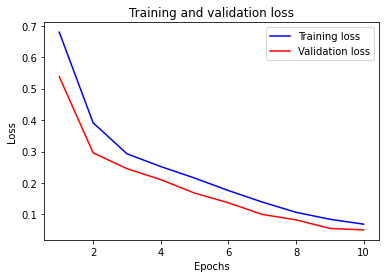

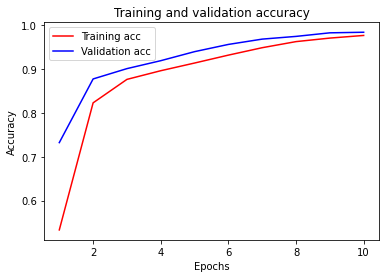

In [59]:
acc = history4_dict['accuracy']
val_acc = history4_dict['val_accuracy']
loss = history4_dict['loss']
val_loss = history4_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 회고

어려웠던 점 
- nlp답게 전처리도 복잡했는데 내용이 헷갈려서 계속 노드를 돌려봤던 것 같다.
- 편의성을 위해 모델을 설계할때 모델이름을 지정했는데 이름 지정중에 공백이 들어가니 오류가 떴다.
- 코딩스킬적인 부분에서 순서에 맞춰 노드에 있는 코드들을 복사하다 보니 코드를 분석하고 이해하는데 어려움이 있었다.

해결방법
- 시간은 오래걸렸지만 원래 노드와 전 수강생분의 코드를 보면서 공부했다.
- 구글링을 통해 모델명을 지정할 때 공백이 들어가서 오류가 났음을 알게 되었지만 이 오류를 잡는데 생각보다 너무 많은 시간이 걸렸다.
- 마찬가지로 노드 코드와 참고 코드를 번갈아가며 이해하도록 노력했다.

루브릭
1. 다양한 방법으로 text classification 테크스를 성공적으로 구현하였다.  
=> 성공적인지는 모르겠으나 일단...노드에서 배운 3가지 모델을 사용하였다.  

2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.  
=> 원래 노드의 틀대로 따라가서 어느 정도는 해결한 것 같다.

3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.  
=> 인천캠분들의 도움으로 달성하긴 했다...다만 그래프가 제 생각보다 너무 이상적으로(?)나와서 무언가 잘못된 것 같기도 하다는 느낌이 들었는데 딱히 오류를 찾지는 못했다. 

느낀점 : 사실 처음에는 노드의 순서를 통해 따라가는 것에 급급해서 이해하는 부분이 부족했는데 다른 조원분들께서 부분부분 어떤 역할을 수행하는지 설명을 해줘서 조금은 이해도도 높이면서 진행한 것 같아서 다른 노드들 보다 뿌듯한 점이 있었지만 그래도 nlp는 아직 어려운 분야인 것 같다는 생각을 했다.

오류 해결 사이트 : https://groups.google.com/g/ml-dl-book-qna/c/sGYNQhDwwO4
참고 코드 주소 : https://github.com/hyyoo3526/AIFFEL_EXPLORATION/blob/main/EXPLORATION_07/EXPLORATION_IC1_07_sentiment_classification.ipynb